In [71]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import math
import re
from collections import Counter
from torch.amp import autocast, GradScaler
import time
import os

# Set environment variable for debugging CUDA errors
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Kiểm tra GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Tham số mô hình
d_model = 64
n_heads = 4
d_k = d_model // n_heads
seq_len = 10
batch_size = 2

Using device: cuda


## Hàm tiền xử lý dữ liệu


In [72]:
def tokenize(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text.split()

def build_vocab(sentences, min_freq=1):
    counter = Counter()
    for sentence in sentences:
        counter.update(tokenize(sentence))

    vocab = {'<pad>': 0, '<unk>': 1, '<sos>': 2, '<eos>': 3}
    vocab.update({word: idx + 4 for idx, (word, freq) in enumerate(counter.items()) if freq >= min_freq})
    return vocab

def sentence_to_indices(sentence, vocab, max_len=seq_len):
    tokens = tokenize(sentence)[:max_len-2]
    indices = [vocab['<sos>']] + [vocab.get(token, vocab['<unk>']) for token in tokens] + [vocab['<eos>']]
    if len(indices) < max_len:
        indices += [vocab['<pad>']] * (max_len - len(indices))
    return indices

def load_and_preprocess_data(csv_path='eng-vie.csv', batch_size=batch_size, max_len=seq_len, d_model=d_model):
    df = pd.read_csv(csv_path)

    en_sentences = df['en'].tolist()
    vi_sentences = df['vi'].tolist()

    en_vocab = build_vocab(en_sentences)
    vi_vocab = build_vocab(vi_sentences)

    en_indices = [sentence_to_indices(sent, en_vocab, max_len) for sent in en_sentences]
    vi_indices = [sentence_to_indices(sent, vi_vocab, max_len) for sent in vi_sentences]

    en_tensor = torch.tensor(en_indices, dtype=torch.long).to(device)
    vi_tensor = torch.tensor(vi_indices, dtype=torch.long).to(device)

    en_embedding = nn.Embedding(len(en_vocab), d_model).to(device)
    vi_embedding = nn.Embedding(len(vi_vocab), d_model).to(device)

    n_samples = len(en_indices)
    indices = torch.randperm(n_samples).to(device)

    for i in range(0, n_samples, batch_size):
        batch_indices = indices[i:i+batch_size]
        batch_en = en_tensor[batch_indices]
        batch_vi = vi_tensor[batch_indices]

        batch_en_embed = en_embedding(batch_en)
        batch_vi_embed = vi_embedding(batch_vi)

        yield batch_en_embed, batch_vi_embed, batch_en, batch_vi, en_vocab, vi_vocab

# Hàm tiện ích (trực quan hóa và đo lường)

In [73]:
def plot_attention_matrix(attention_matrix, title="Attention Matrix"):
    plt.figure(figsize=(8, 6))
    plt.imshow(attention_matrix, cmap="viridis")
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Key position")
    plt.ylabel("Query position")
    plt.tight_layout()
    plt.show()

def plot_complexity_comparison():
    n_values = np.arange(100, 10001, 100)

    mha_complexity = n_values**2
    mqa_complexity = n_values**2 * 0.8
    gqa_complexity = n_values**2 * 0.9
    flash_complexity = n_values**2 * 0.6
    linear_complexity = n_values
    sparse_complexity = n_values * np.log(n_values)
    rope_complexity = n_values**2 * 1.1

    plt.figure(figsize=(12, 8))
    plt.plot(n_values, mha_complexity, label="Self-Attention (MHA): O(n²)", linewidth=2)
    plt.plot(n_values, mqa_complexity, label="Multi-Query Attention (MQA): O(n²)", linewidth=2)
    plt.plot(n_values, gqa_complexity, label="Grouped-Query Attention (GQA): O(n²)", linewidth=2)
    plt.plot(n_values, flash_complexity, label="FlashAttention: O(n²)", linewidth=2)
    plt.plot(n_values, linear_complexity, label="Linear Attention: O(n)", linewidth=2)
    plt.plot(n_values, sparse_complexity, label="Sparse Attention: O(n log n)", linewidth=2)
    plt.plot(n_values, rope_complexity, label="RoPE: O(n²)", linewidth=2)

    plt.xlabel("Độ dài chuỗi (n)")
    plt.ylabel("Độ phức tạp tính toán (tương đối)")
    plt.title("So sánh độ phức tạp tính toán")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.yscale("log")
    plt.tight_layout()
    plt.show()

def plot_memory_comparison():
    n_values = np.arange(100, 10001, 100)
    h = 16
    g = 4

    mha_memory = 2 * h * n_values
    mqa_memory = 2 * n_values
    gqa_memory = 2 * g * n_values
    flash_memory = n_values
    linear_memory = n_values
    sparse_memory = n_values * np.log(n_values)
    rope_memory = 2 * h * n_values

    plt.figure(figsize=(12, 8))
    plt.plot(n_values, mha_memory, label=f"Self-Attention (MHA): 2 × {h} × n", linewidth=2)
    plt.plot(n_values, mqa_memory, label="Multi-Query (MQA): 2 × n", linewidth=2)
    plt.plot(n_values, gqa_memory, label=f"Grouped-Query (GQA): 2 × {g} × n", linewidth=2)
    plt.plot(n_values, flash_memory, label="FlashAttention: O(n)", linewidth=2)
    plt.plot(n_values, linear_memory, label="Linear Attention: O(n)", linewidth=2)
    plt.plot(n_values, sparse_memory, label="Sparse Attention: O(n log n)", linewidth=2)
    plt.plot(n_values, rope_memory, label=f"RoPE: 2 × {h} × n", linewidth=2)

    plt.xlabel("Độ dài chuỗi (n)")
    plt.ylabel("Yêu cầu bộ nhớ (tương đối)")
    plt.title("So sánh yêu cầu bộ nhớ")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.yscale("log")
    plt.tight_layout()
    plt.show()

def measure_performance(model, data_generator, model_name):
    model.eval()
    torch.cuda.empty_cache()
    start_mem = torch.cuda.memory_allocated(device) / 1024**2
    peak_mem = start_mem
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)

    start_event.record()
    with autocast('cuda'):
        for batch_en_embed, _, _, batch_vi, _, _ in data_generator:
            output = model(batch_en_embed)
            current_mem = torch.cuda.memory_allocated(device) / 1024**2
            peak_mem = max(peak_mem, current_mem)
    end_event.record()

    torch.cuda.synchronize()
    elapsed_time = start_event.elapsed_time(end_event) / 1000
    mem_used = peak_mem - start_mem

    print(f"{model_name}: Time = {elapsed_time:.4f}s, Memory = {mem_used:.2f}MB")
    return elapsed_time, mem_used

## 1. Self-Attention

Self-Attention là nền tảng của kiến trúc Transformer, cho phép mỗi token tương tác với tất cả các token khác trong chuỗi. Cơ chế này tính toán ma trận attention đầy đủ với độ phức tạp O(n²).

### Nguyên lý hoạt động

1. Tạo ra các vector Query (Q), Key (K) và Value (V) cho mỗi token
2. Tính điểm số attention bằng tích vô hướng giữa Q và K
3. Chuẩn hóa điểm số bằng hàm softmax
4. Tính đầu ra bằng cách nhân trọng số attention với V

### Công thức toán học

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

### Cài đặt


In [74]:
class SelfAttention(nn.Module):
    def __init__(self, d_model, n_heads, vocab_size):
        super(SelfAttention, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.vocab_size = vocab_size

        self.W_q = nn.Linear(d_model, d_model).to(device)
        self.W_k = nn.Linear(d_model, d_model).to(device)
        self.W_v = nn.Linear(d_model, d_model).to(device)
        self.W_o = nn.Linear(d_model, d_model).to(device)
        self.proj = nn.Linear(d_model, vocab_size).to(device)

    def split_heads(self, x):
        batch_size, seq_len = x.size(0), x.size(1)
        x = x.view(batch_size, seq_len, self.n_heads, self.d_k)
        return x.transpose(1, 2)

    def forward(self, x, return_attention=False):
        batch_size, seq_len = x.size(0), x.size(1)

        q = self.W_q(x)
        k = self.W_k(x)
        v = self.W_v(x)

        q = self.split_heads(q)
        k = self.split_heads(k)
        v = self.split_heads(v)

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
        attention_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, v)

        output = output.transpose(1, 2).contiguous()
        output = output.view(batch_size, seq_len, self.n_heads * self.d_k)
        output = self.W_o(output)

        logits = self.proj(output)

        if return_attention:
            return logits, attention_weights
        return logits

## 2. Multi-Query Attention (MQA)

Multi-Query Attention (MQA) là một biến thể của self-attention, giảm yêu cầu bộ nhớ bằng cách sử dụng chung một ma trận Key và một ma trận Value cho tất cả các đầu attention, chỉ có ma trận Query là khác nhau giữa các đầu.

### Nguyên lý hoạt động

1. Tạo ra nhiều vector Query (Q) khác nhau cho mỗi đầu attention
2. Tạo ra một vector Key (K) và một vector Value (V) dùng chung cho tất cả các đầu
3. Tính điểm số attention cho mỗi đầu bằng tích vô hướng giữa Q và K
4. Chuẩn hóa điểm số bằng hàm softmax
5. Tính đầu ra cho mỗi đầu bằng cách nhân trọng số attention với V

### Cài đặt


In [75]:
class MultiQueryAttention(nn.Module):
    def __init__(self, d_model, n_heads, vocab_size):
        super(MultiQueryAttention, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.vocab_size = vocab_size

        self.W_q = nn.Linear(d_model, d_model).to(device)
        self.W_k = nn.Linear(d_model, self.d_k).to(device)
        self.W_v = nn.Linear(d_model, self.d_k).to(device)
        self.W_o = nn.Linear(d_model, d_model).to(device)
        self.proj = nn.Linear(d_model, vocab_size).to(device)

    def split_heads(self, x, is_kv=False):
        batch_size, seq_len = x.size(0), x.size(1)
        if is_kv:
            return x.unsqueeze(1).expand(-1, self.n_heads, -1, -1)
        x = x.view(batch_size, seq_len, self.n_heads, self.d_k)
        return x.transpose(1, 2)

    def forward(self, x, return_attention=False):
        batch_size, seq_len = x.size(0), x.size(1)

        q = self.W_q(x)
        k = self.W_k(x)
        v = self.W_v(x)

        q = self.split_heads(q)
        k = self.split_heads(k, is_kv=True)
        v = self.split_heads(v, is_kv=True)

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
        attention_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, v)

        output = output.transpose(1, 2).contiguous()
        output = output.view(batch_size, seq_len, self.n_heads * self.d_k)
        output = self.W_o(output)

        logits = self.proj(output)

        if return_attention:
            return logits, attention_weights
        return logits

## 3. Grouped-Query Attention (GQA)

Grouped-Query Attention (GQA) là một sự cân bằng giữa MHA và MQA, chia các đầu attention thành các nhóm, mỗi nhóm dùng chung một ma trận Key và một ma trận Value.

### Nguyên lý hoạt động

1. Chia các đầu attention thành G nhóm (với G < H)
2. Mỗi đầu có ma trận Query (Q) riêng biệt
3. Các đầu trong cùng một nhóm dùng chung ma trận Key (K) và Value (V)
4. Tính điểm số attention cho mỗi đầu bằng tích vô hướng giữa Q và K của nhóm tương ứng
5. Chuẩn hóa điểm số bằng hàm softmax
6. Tính đầu ra cho mỗi đầu bằng cách nhân trọng số attention với V của nhóm tương ứng

### Cài đặt


In [76]:
class GroupedQueryAttention(nn.Module):
    def __init__(self, d_model, n_heads, n_groups, vocab_size):
        super(GroupedQueryAttention, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.n_groups = n_groups
        self.d_k = d_model // n_heads
        self.heads_per_group = n_heads // n_groups
        self.vocab_size = vocab_size

        self.W_q = nn.Linear(d_model, d_model).to(device)
        self.W_k = nn.Linear(d_model, self.d_k * n_groups).to(device)
        self.W_v = nn.Linear(d_model, self.d_k * n_groups).to(device)
        self.W_o = nn.Linear(d_model, d_model).to(device)
        self.proj = nn.Linear(d_model, vocab_size).to(device)

    def split_heads(self, x, is_kv=False):
        batch_size, seq_len = x.size(0), x.size(1)
        if is_kv:
            # x shape: [batch_size, seq_len, n_groups * d_k]
            x = x.view(batch_size, seq_len, self.n_groups, self.d_k)
            # Repeat each group to match n_heads
            x = x.repeat(1, 1, self.heads_per_group, 1)
            x = x.view(batch_size, seq_len, self.n_heads, self.d_k)
            return x.transpose(1, 2)  # [batch_size, n_heads, seq_len, d_k]
        else:
            # Query: [batch_size, seq_len, d_model]
            x = x.view(batch_size, seq_len, self.n_heads, self.d_k)
            return x.transpose(1, 2)  # [batch_size, n_heads, seq_len, d_k]

    def forward(self, x, return_attention=False):
        batch_size, seq_len = x.size(0), x.size(1)

        q = self.W_q(x)
        k = self.W_k(x)
        v = self.W_v(x)

        q = self.split_heads(q)
        k = self.split_heads(k, is_kv=True)
        v = self.split_heads(v, is_kv=True)

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
        attention_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, v)

        output = output.transpose(1, 2).contiguous()
        output = output.view(batch_size, seq_len, self.n_heads * self.d_k)
        output = self.W_o(output)

        logits = self.proj(output)

        if return_attention:
            return logits, attention_weights
        return logits

## 4. Linear Attention

Linear Attention giảm độ phức tạp tính toán và bộ nhớ từ O(n²) xuống O(n) bằng cách sử dụng các hàm ánh xạ đặc trưng thay cho hàm softmax.

### Nguyên lý hoạt động

1. Áp dụng hàm ánh xạ đặc trưng φ cho các ma trận Query và Key
2. Tính ma trận trung gian KV = φ(K)^T × V
3. Tính đầu ra cuối cùng Output = φ(Q) × KV
4. Chuẩn hóa đầu ra (tùy chọn)

### Công thức toán học

$$\text{LinearAttention}(Q, K, V) = \phi(Q) \times (\phi(K)^T \times V)$$

### Cài đặt


In [77]:
class LinearAttention(nn.Module):
    def __init__(self, d_model, vocab_size):
        super(LinearAttention, self).__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.W_q = nn.Linear(d_model, d_model).to(device)
        self.W_k = nn.Linear(d_model, d_model).to(device)
        self.W_v = nn.Linear(d_model, d_model).to(device)
        self.W_o = nn.Linear(d_model, d_model).to(device)
        self.proj = nn.Linear(d_model, vocab_size).to(device)

    def forward(self, x, return_attention=False):
        batch_size, seq_len = x.size(0), x.size(1)

        q = self.W_q(x)
        k = self.W_k(x)
        v = self.W_v(x)

        q = F.elu(q) + 1
        k = F.elu(k) + 1

        kv = torch.matmul(k.transpose(-2, -1), v)
        z = k.sum(dim=1)

        output = torch.matmul(q, kv)
        z = torch.matmul(q, z.unsqueeze(-1)).squeeze(-1)
        output = output / (z.unsqueeze(-1) + 1e-8)

        output = self.W_o(output)
        logits = self.proj(output)

        if return_attention:
            scores = torch.matmul(q, k.transpose(-2, -1))
            attention_weights = scores / (scores.sum(dim=-1, keepdim=True) + 1e-8)
            attention_weights = attention_weights.unsqueeze(1)
            return logits, attention_weights
        return logits

## 5. Sparse Attention

Sparse Attention chỉ tính toán attention cho một tập con các cặp token thay vì tất cả các cặp có thể, giảm độ phức tạp xuống O(n√n) hoặc thậm chí O(n·log(n)).

### Nguyên lý hoạt động

1. Tạo ra một ma trận mặt nạ thưa (sparse mask) để xác định các cặp token nào được phép tương tác
2. Tính điểm số attention như trong self-attention thông thường
3. Áp dụng mặt nạ để chỉ giữ lại các điểm số cho các cặp token được phép tương tác
4. Áp dụng softmax và tính đầu ra như thông thường

### Cài đặt (Local Banded Pattern)


In [78]:
class SparseAttention(nn.Module):
    def __init__(self, d_model, n_heads, top_k=5, vocab_size=None):
        super(SparseAttention, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.top_k = top_k
        self.vocab_size = vocab_size

        self.W_q = nn.Linear(d_model, d_model).to(device)
        self.W_k = nn.Linear(d_model, d_model).to(device)
        self.W_v = nn.Linear(d_model, d_model).to(device)
        self.W_o = nn.Linear(d_model, d_model).to(device)
        self.proj = nn.Linear(d_model, vocab_size).to(device)

    def split_heads(self, x):
        batch_size, seq_len = x.size(0), x.size(1)
        x = x.view(batch_size, seq_len, self.n_heads, self.d_k)
        return x.transpose(1, 2)

    def forward(self, x, return_attention=False):
        batch_size, seq_len = x.size(0), x.size(1)

        q = self.W_q(x)
        k = self.W_k(x)
        v = self.W_v(x)

        q = self.split_heads(q)
        k = self.split_heads(k)
        v = self.split_heads(v)

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)

        top_k_scores, top_k_indices = torch.topk(scores, self.top_k, dim=-1)
        sparse_attention = torch.zeros_like(scores).scatter_(-1, top_k_indices, top_k_scores)
        attention_weights = F.softmax(sparse_attention, dim=-1)

        output = torch.matmul(attention_weights, v)
        output = output.transpose(1, 2).contiguous()
        output = output.view(batch_size, seq_len, self.n_heads * self.d_k)
        output = self.W_o(output)

        logits = self.proj(output)

        if return_attention:
            return logits, attention_weights
        return logits

## 6. Rotary Positional Embedding (RoPE)

Rotary Positional Embedding (RoPE) mã hóa thông tin vị trí thông qua phép xoay trong không gian phức, kết hợp cả thông tin vị trí tuyệt đối và tương đối.

### Nguyên lý hoạt động

1. Biểu diễn mỗi cặp chiều liền kề trong vector embedding như một số phức
2. Áp dụng phép xoay với góc phụ thuộc vào vị trí của token và tần số của chiều embedding
3. Áp dụng phép xoay này cho cả query và key trước khi tính toán attention

### Công thức toán học

$$R_\theta^i(x_{2i}, x_{2i+1}, m) = [x_{2i}\cos(\theta_i \cdot m) - x_{2i+1}\sin(\theta_i \cdot m), x_{2i}\sin(\theta_i \cdot m) + x_{2i+1}\cos(\theta_i \cdot m)]$$

### Cài đặt


In [79]:
class RotaryPositionalEmbedding(nn.Module):
    def __init__(self, d_k, max_len=seq_len):
        super(RotaryPositionalEmbedding, self).__init__()
        self.d_k = d_k
        theta = 10000 ** (-2 * torch.arange(0, d_k//2) / d_k).to(device)
        positions = torch.arange(max_len).unsqueeze(1).to(device)
        angles = positions * theta
        self.rotary_matrix = torch.stack([torch.cos(angles), -torch.sin(angles), torch.sin(angles), torch.cos(angles)], dim=-1)
        self.rotary_matrix = self.rotary_matrix.view(max_len, d_k//2, 2, 2)

    def apply_rotary(self, x):
        batch_size, n_heads, seq_len, d_k = x.size()
        x = x.view(batch_size, n_heads, seq_len, d_k//2, 2)
        rotary = self.rotary_matrix[:seq_len].to(x.device)
        x_rotated = torch.einsum('bhslc,slcd->bhsld', x, rotary)
        return x_rotated.reshape(batch_size, n_heads, seq_len, d_k)

class RoPESelfAttention(nn.Module):
    def __init__(self, d_model, n_heads, vocab_size):
        super(RoPESelfAttention, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.vocab_size = vocab_size

        self.W_q = nn.Linear(d_model, d_model).to(device)
        self.W_k = nn.Linear(d_model, d_model).to(device)
        self.W_v = nn.Linear(d_model, d_model).to(device)
        self.W_o = nn.Linear(d_model, d_model).to(device)
        self.rope = RotaryPositionalEmbedding(self.d_k, seq_len)
        self.proj = nn.Linear(d_model, vocab_size).to(device)

    def split_heads(self, x):
        batch_size, seq_len = x.size(0), x.size(1)
        x = x.view(batch_size, seq_len, self.n_heads, self.d_k)
        return x.transpose(1, 2)

    def forward(self, x, return_attention=False):
        batch_size, seq_len = x.size(0), x.size(1)

        q = self.W_q(x)
        k = self.W_k(x)
        v = self.W_v(x)

        q = self.split_heads(q)
        k = self.split_heads(k)
        v = self.split_heads(v)

        q = self.rope.apply_rotary(q)
        k = self.rope.apply_rotary(k)

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
        attention_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, v)

        output = output.transpose(1, 2).contiguous()
        output = output.view(batch_size, seq_len, self.n_heads * self.d_k)
        output = self.W_o(output)

        logits = self.proj(output)

        if return_attention:
            return logits, attention_weights
        return logits

## 7. FlashAttention v2

FlashAttention v2 là một cải tiến về tốc độ và hiệu quả bộ nhớ cho cơ chế attention, tập trung vào việc tối ưu hóa IO-aware để giảm thiểu việc truy cập vào HBM (High Bandwidth Memory).

### Nguyên lý hoạt động

1. Chia ma trận Q, K, V thành các block nhỏ phù hợp với kích thước bộ nhớ cache
2. Tính attention theo từng block, tối ưu tái sử dụng bộ nhớ
3. Sử dụng kỹ thuật tiled matrix multiplication để giảm IO cost
4. Triển khai các phép toán fused kernel để tăng tốc độ

### Ưu điểm chính:

-   Độ phức tạp bộ nhớ O(N) thay vì O(N²)
-   Tăng tốc 2-4x so với triển khai attention thông thường
-   Cho phép xử lý chuỗi dài hơn với cùng lượng bộ nhớ

### Cài đặt


In [80]:
class FlashAttention(nn.Module):
    def __init__(self, d_model, n_heads, vocab_size):
        super(FlashAttention, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads
        self.vocab_size = vocab_size

        self.W_q = nn.Linear(d_model, d_model).to(device)
        self.W_k = nn.Linear(d_model, d_model).to(device)
        self.W_v = nn.Linear(d_model, d_model).to(device)
        self.W_o = nn.Linear(d_model, d_model).to(device)
        self.proj = nn.Linear(d_model, vocab_size).to(device)

    def split_heads(self, x):
        batch_size, seq_len = x.size(0), x.size(1)
        x = x.view(batch_size, seq_len, self.n_heads, self.d_k)
        return x.transpose(1, 2)

    def forward(self, x, return_attention=False):
        batch_size, seq_len = x.size(0), x.size(1)

        q = self.W_q(x)
        k = self.W_k(x)
        v = self.W_v(x)

        q = self.split_heads(q)
        k = self.split_heads(k)
        v = self.split_heads(v)

        output = F.scaled_dot_product_attention(q, k, v, is_causal=False)

        output = output.transpose(1, 2).contiguous()
        output = output.view(batch_size, seq_len, self.n_heads * self.d_k)
        output = self.W_o(output)

        logits = self.proj(output)

        if return_attention:
            scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)
            attention_weights = F.softmax(scores, dim=-1)
            return logits, attention_weights
        return logits

# Hàm huấn luyện và đánh giá

In [81]:
def train_attention_model(model, csv_path, vi_vocab, epochs=10, batch_size=batch_size, max_len=seq_len, d_model=d_model):
    criterion = nn.CrossEntropyLoss(ignore_index=0).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scaler = GradScaler('cuda')

    for epoch in range(epochs):
        total_loss = 0
        batch_count = 0
        batch_generator = load_and_preprocess_data(csv_path, batch_size, max_len, d_model)

        for batch_en_embed, _, _, batch_vi, _, _ in batch_generator:
            model.train()
            optimizer.zero_grad()

            with autocast('cuda'):
                logits = model(batch_en_embed)  # (batch_size, seq_len, vocab_size)
                batch_size_actual, seq_len_actual = batch_en_embed.size(0), batch_en_embed.size(1)
                logits = logits.view(batch_size_actual * seq_len_actual, len(vi_vocab))
                target = batch_vi.view(-1)

                loss = criterion(logits, target)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
            batch_count += 1

        avg_loss = total_loss / (batch_count or 1)
        print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}")

    return model

def visualize_trained_attention(model, csv_path, batch_size=batch_size, max_len=seq_len, d_model=d_model):
    batch_generator = load_and_preprocess_data(csv_path, batch_size, max_len, d_model)
    batch_en_embed, _, _, _, _, _ = next(batch_generator)

    model.eval()
    with torch.no_grad(), autocast('cuda'):
        logits, attention_weights = model(batch_en_embed, return_attention=True)

    attention_matrix = attention_weights[0, 0].cpu().numpy()
    plot_attention_matrix(attention_matrix, title=f"Trained {model.__class__.__name__} Matrix (Head 1)")

1. SelfAttention: Triển khai chuẩn với độ phức tạp O(n²), sử dụng đầy đủ các ma trận Q, K, V cho mỗi đầu.
2. MultiQueryAttention (MQA): Giảm bộ nhớ bằng cách chia sẻ K và V cho tất cả các đầu, chỉ có Q riêng biệt.
3. GroupedQueryAttention (GQA): Cân bằng giữa MHA và MQA, chia đầu thành nhóm, mỗi nhóm dùng chung K và V.
4. LinearAttention: Giảm độ phức tạp xuống O(n) bằng cách sử dụng hàm ánh xạ đặc trưng thay vì softmax.
5. SparseAttention: Chỉ tính attention cho top-k token, giảm độ phức tạp xuống O(n log n).
6. RoPESelfAttention: Sử dụng Rotary Positional Embeddings (RoPE) để mã hóa vị trí, thêm phép xoay vào Q và K.
7. FlashAttention: Sử dụng F.scaled_dot_product_attention (PyTorch 2.0+), tối ưu cho GPU với các phép tính hợp nhất.

# Chạy huấn luyện, đo lường và so sánh


Training SelfAttention...
Epoch 1/2, Average Loss: 4.4997
Epoch 2/2, Average Loss: 4.2912


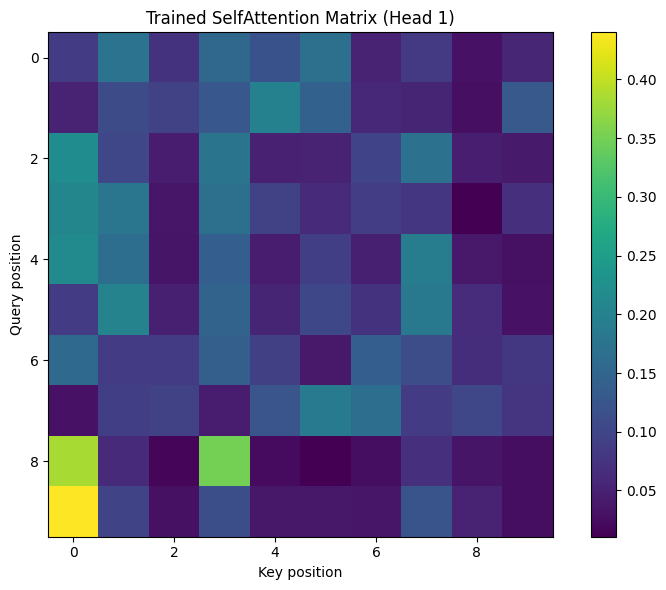

SelfAttention: Time = 6.0882s, Memory = 0.46MB

Training MultiQueryAttention...
Epoch 1/2, Average Loss: 4.5336
Epoch 2/2, Average Loss: 4.3428


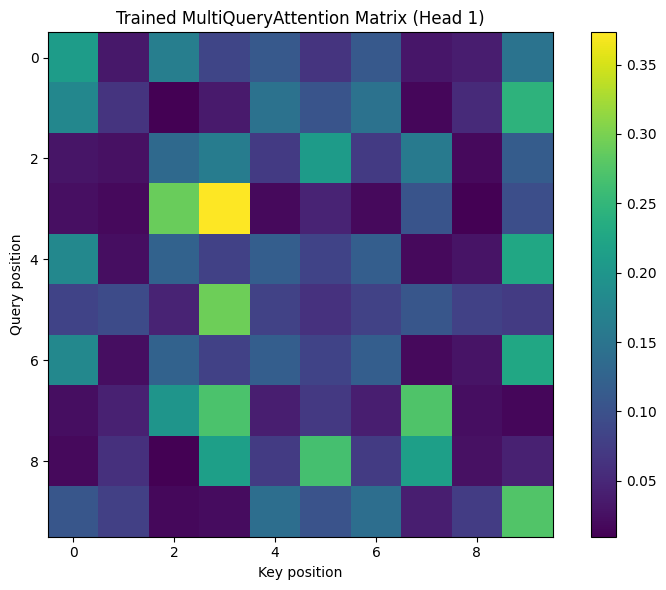

MultiQueryAttention: Time = 6.4214s, Memory = 3.59MB

Training GroupedQueryAttention...
Epoch 1/2, Average Loss: 4.5459
Epoch 2/2, Average Loss: 4.3286


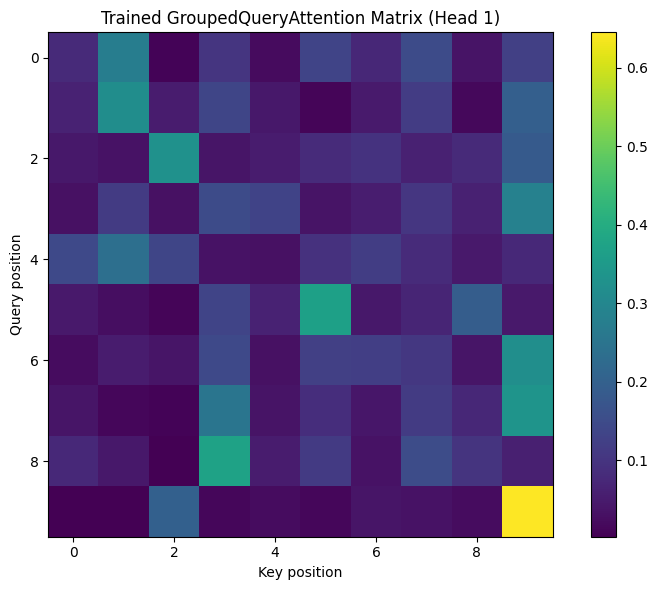

GroupedQueryAttention: Time = 6.7371s, Memory = 3.59MB

Training LinearAttention...
Epoch 1/2, Average Loss: 4.6199
Epoch 2/2, Average Loss: 4.4039


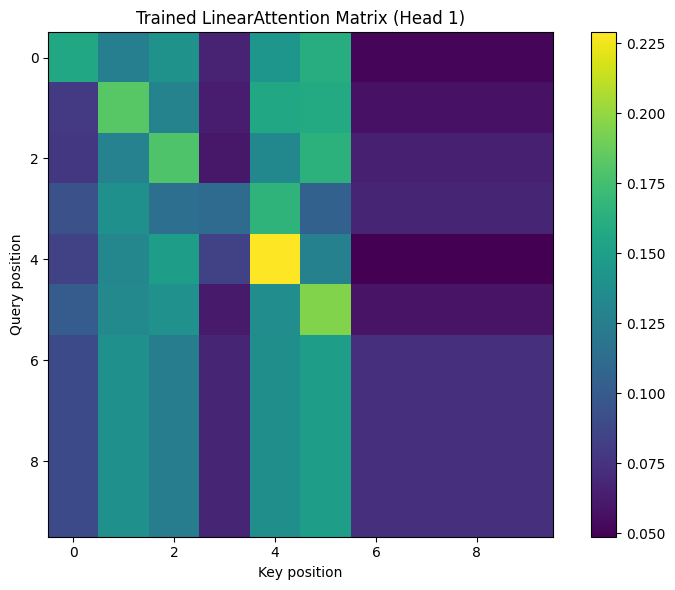

LinearAttention: Time = 6.2096s, Memory = 3.61MB

Training SparseAttention...
Epoch 1/2, Average Loss: 4.5154
Epoch 2/2, Average Loss: 4.3031


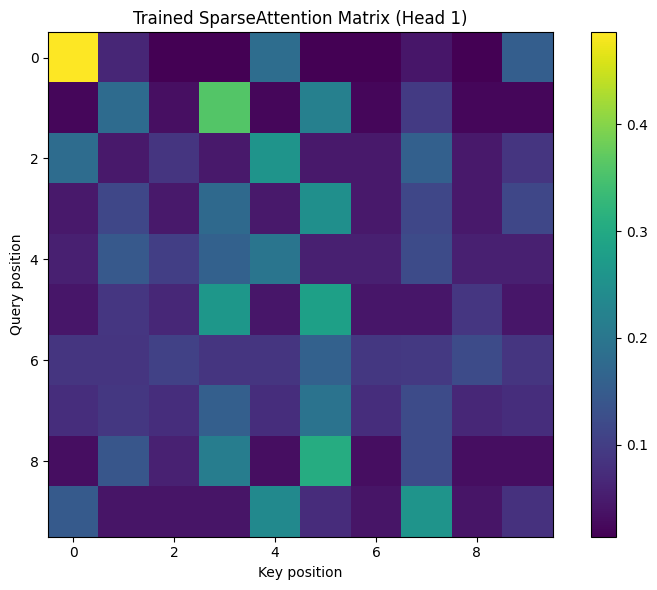

SparseAttention: Time = 6.9414s, Memory = 3.61MB

Training RoPESelfAttention...
Epoch 1/2, Average Loss: 4.4300
Epoch 2/2, Average Loss: 4.1871


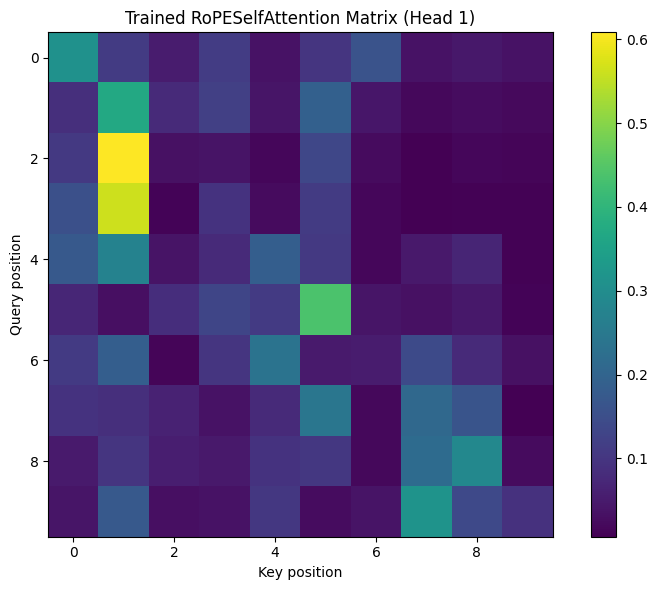

RoPESelfAttention: Time = 8.3074s, Memory = 3.60MB

Training FlashAttention...
Epoch 1/2, Average Loss: 4.5249
Epoch 2/2, Average Loss: 4.3153


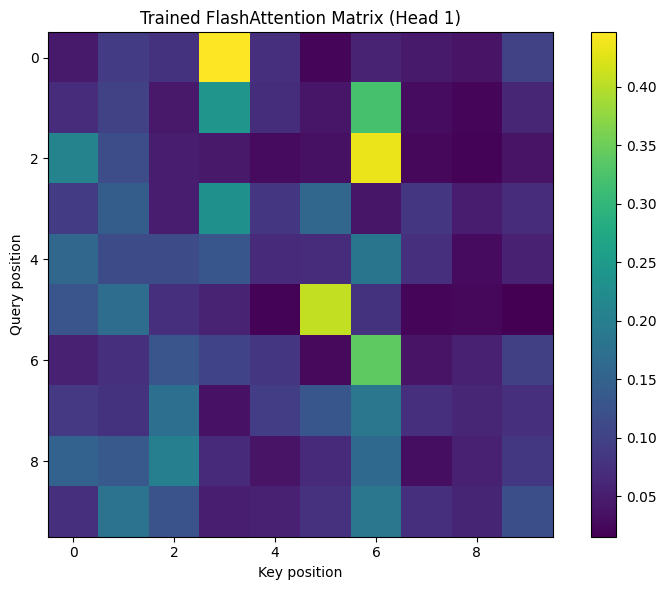

FlashAttention: Time = 4.5228s, Memory = 3.59MB

Performance Comparison:
SelfAttention: Time = 6.0882s, Memory = 0.46MB
MultiQueryAttention: Time = 6.4214s, Memory = 3.59MB
GroupedQueryAttention: Time = 6.7371s, Memory = 3.59MB
LinearAttention: Time = 6.2096s, Memory = 3.61MB
SparseAttention: Time = 6.9414s, Memory = 3.61MB
RoPESelfAttention: Time = 8.3074s, Memory = 3.60MB
FlashAttention: Time = 4.5228s, Memory = 3.59MB


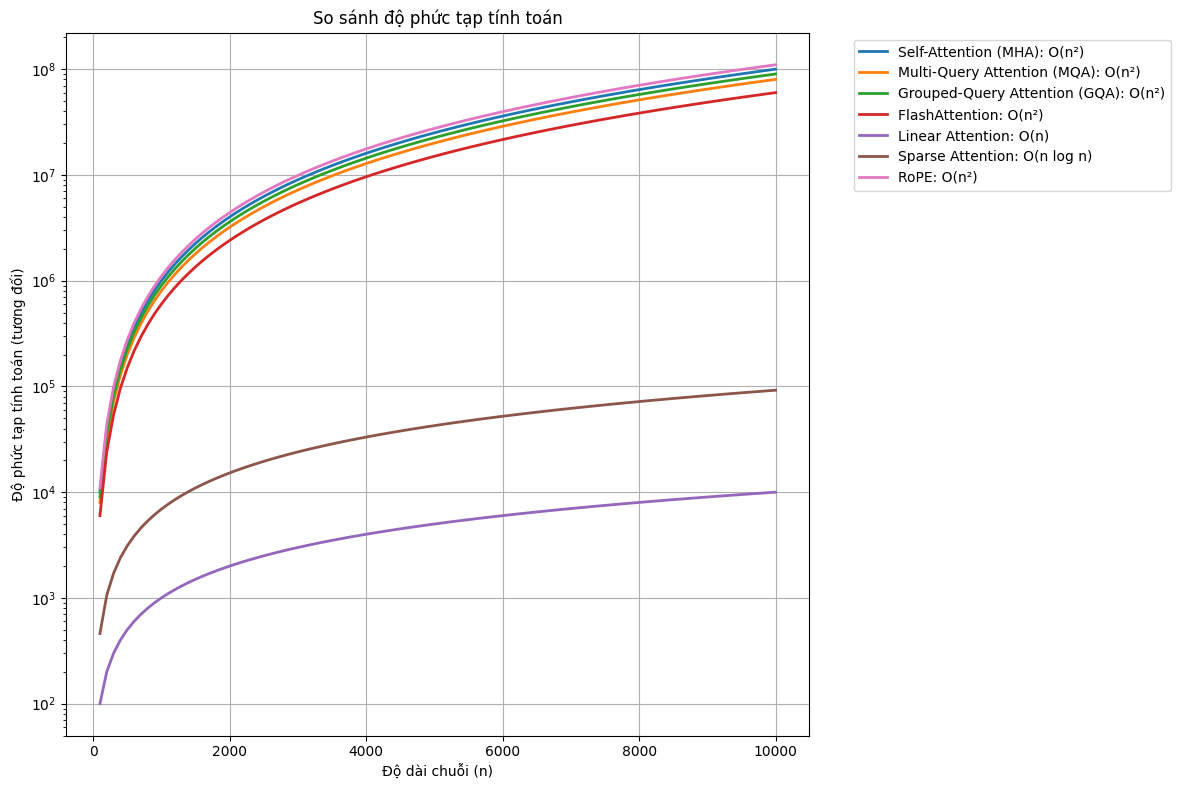

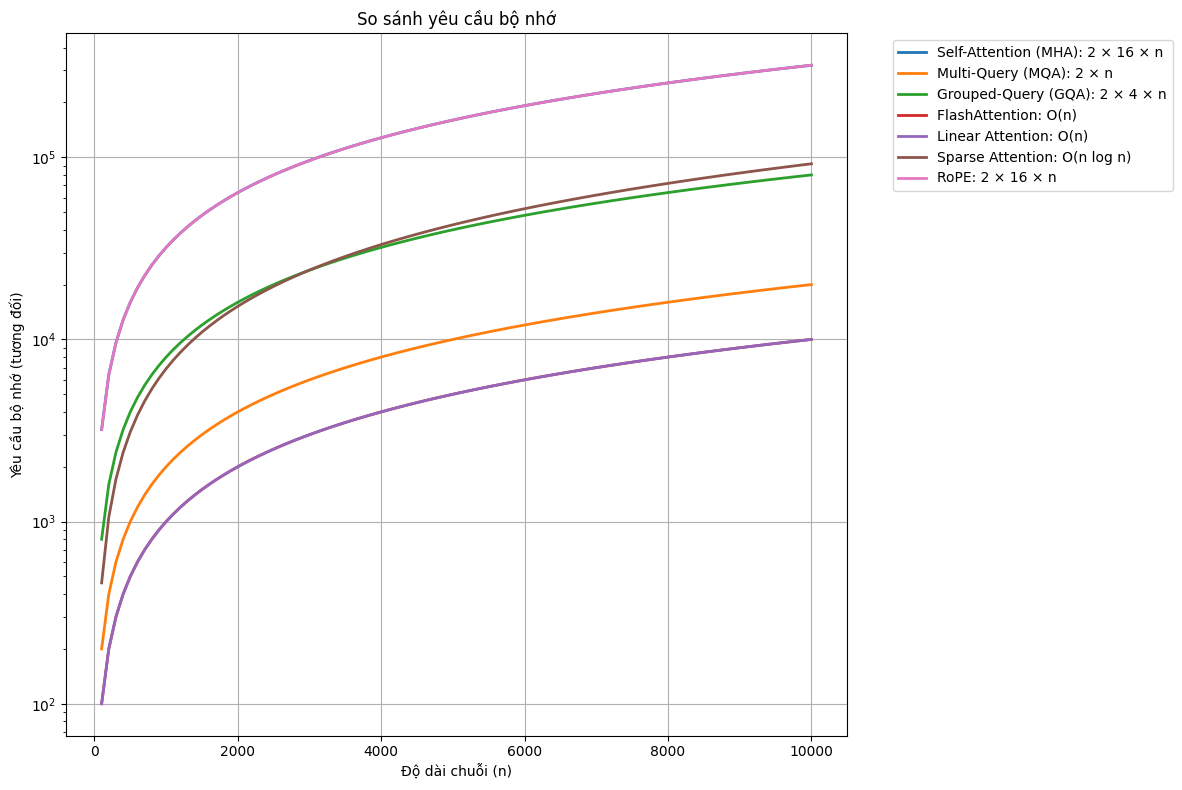

In [82]:
csv_path = '/content/eng-vie.csv'
batch_generator = load_and_preprocess_data(csv_path)
_, _, _, _, _, vi_vocab = next(batch_generator)

models = [
    (SelfAttention(d_model, n_heads, len(vi_vocab)), "SelfAttention"),
    (MultiQueryAttention(d_model, n_heads, len(vi_vocab)), "MultiQueryAttention"),
    (GroupedQueryAttention(d_model, n_heads, n_groups=2, vocab_size=len(vi_vocab)), "GroupedQueryAttention"),
    (LinearAttention(d_model, len(vi_vocab)), "LinearAttention"),
    (SparseAttention(d_model, n_heads, top_k=5, vocab_size=len(vi_vocab)), "SparseAttention"),
    (RoPESelfAttention(d_model, n_heads, len(vi_vocab)), "RoPESelfAttention"),
    (FlashAttention(d_model, n_heads, len(vi_vocab)), "FlashAttention")
]

performance_results = []
for model, name in models:
    print(f"\nTraining {name}...")
    trained_model = train_attention_model(model, csv_path, vi_vocab, epochs=2)
    visualize_trained_attention(trained_model, csv_path)

    batch_generator = load_and_preprocess_data(csv_path)
    time_taken, mem_used = measure_performance(trained_model, batch_generator, name)
    performance_results.append((name, time_taken, mem_used))

print("\nPerformance Comparison:")
for name, time_taken, mem_used in performance_results:
    print(f"{name}: Time = {time_taken:.4f}s, Memory = {mem_used:.2f}MB")

plot_complexity_comparison()
plot_memory_comparison()